In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from beartype import beartype as typed
from beartype.door import die_if_unbearable as assert_type
from einops import einops as ein
from jaxtyping import Bool, Float, Int
from torch import Tensor as TT

from utils import seed_everything, ls
from sparse_autoencoders import toy_problem, SparseAutoEncoder, fit_sae

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


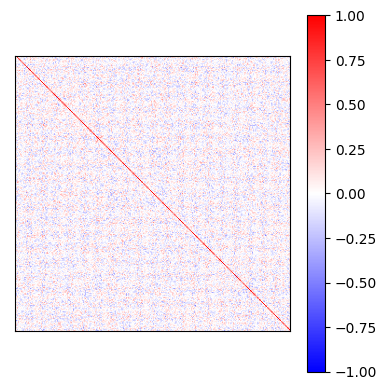

In [129]:
seed_everything(42)

n_samples = 10**4
d_sparse = 50
d_dense = 256

dense, sparse, directions = toy_problem(
    n_samples=n_samples,
    d_sparse=d_sparse,
    d_dense=d_dense,
    ortho=False,
    freq_decay=0.95,
    nonzero_rate=2.0,
)
assert_type(directions, Float[TT, "d_sparse d_dense"])


dir_cos: Float[TT, "d_sparse d_sparse"] = F.cosine_similarity(
    directions[:, None], directions[None, :], dim=-1
)
assert dir_cos[3, 5] == F.cosine_similarity(directions[3], directions[5], dim=-1)
plt.figure(figsize=(4, 4))
plt.imshow(dir_cos, vmin=-1, vmax=1, cmap="bwr")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

In [137]:
from sparse_autoencoders import SparseAutoEncoder, fit_sae, max_cosine_similarity

# seed_everything(42)

d_dict = 52
sae = SparseAutoEncoder(d_dense, d_dict)
others = [SparseAutoEncoder(d_dense, int(k * d_dict)) for k in []]

for it in range(20):
    alpha = 0.1
    l1 = 0.003
    fit_sae(sae, dense, lr=1e-2, l1=l1, alpha=alpha, epochs=10, batch_size=2500)

    # for other in others:
    #     fit_sae(other, dense, lr=1e-2, l1=l1, alpha=alpha, epochs=1, batch_size=2500)
    # other_guesses = [other.encode(dense).detach() for other in others]

    guess = sae.encode(dense).detach()
    assert_type(guess, Float[TT, "n_samples d_dict"])
    alive_count = (guess > 0).sum(dim=0)
    dead = (alive_count == 0).sum()
    print("dead =", dead.item())

    true_vs_guess = max_cosine_similarity(target=sparse, learned=guess)
    print(ls(true_vs_guess.mean()), ls(true_vs_guess))

    # guess_vs_others = [
    #     max_cosine_similarity(target=guess, learned=other) for other in other_guesses
    # ]
    # average = sum(guess_vs_others) / len(guess_vs_others)
    # print(ls(average.mean()), ls(average))

    guess_vs_true = max_cosine_similarity(target=guess, learned=sparse)
    print(ls(guess_vs_true.mean()), ls(guess_vs_true))

100%|██████████| 10/10 [00:00<00:00, 12.28it/s,  loss=0.29, nonzero=24.28 / 52, nonorth=0.02]


dead = 0
0.41 [ 0.67 0.61 0.74 0.66 0.77 0.57 0.50 0.76 0.52 0.55 0.56 0.57 0.60 0.53 0.48 0.42 0.61 0.50 0.44 0.36 0.48 0.47 0.42 0.41 0.35 0.36 0.31 0.39 0.33 0.34 0.31 0.48 0.27 0.39 0.23 0.30 0.31 0.39 0.25 0.19 0.24 0.24 0.21 0.15 0.22 0.21 0.15 0.17 0.14 0.15 ]
0.51 [ 0.53 0.48 0.76 0.50 0.55 0.51 0.77 0.70 0.61 0.37 0.43 0.49 0.60 0.41 0.61 0.39 0.37 0.41 0.41 0.40 0.43 0.42 0.52 0.60 0.56 0.57 0.47 0.46 0.49 0.40 0.37 0.48 0.66 0.64 0.51 0.39 0.55 0.39 0.54 0.50 0.48 0.74 0.46 0.67 0.45 0.47 0.61 0.52 0.61 0.40 0.50 0.51 ]


100%|██████████| 10/10 [00:00<00:00, 12.44it/s,  loss=0.09, nonzero=28.71 / 52, nonorth=0.01]


dead = 0
0.34 [ 0.53 0.56 0.62 0.51 0.73 0.56 0.43 0.63 0.45 0.49 0.44 0.50 0.48 0.39 0.46 0.41 0.39 0.42 0.36 0.32 0.37 0.39 0.31 0.39 0.31 0.31 0.29 0.27 0.27 0.28 0.26 0.27 0.24 0.27 0.21 0.28 0.23 0.19 0.19 0.20 0.18 0.21 0.20 0.14 0.19 0.17 0.13 0.16 0.16 0.19 ]
0.43 [ 0.39 0.41 0.63 0.41 0.49 0.56 0.73 0.61 0.51 0.27 0.32 0.54 0.47 0.33 0.51 0.33 0.32 0.38 0.34 0.35 0.35 0.40 0.47 0.48 0.44 0.50 0.42 0.36 0.45 0.28 0.35 0.37 0.48 0.43 0.56 0.27 0.48 0.30 0.51 0.31 0.46 0.62 0.39 0.52 0.42 0.39 0.43 0.44 0.43 0.43 0.40 0.53 ]


100%|██████████| 10/10 [00:00<00:00, 13.56it/s,  loss=0.06, nonzero=29.93 / 52, nonorth=0.01]


dead = 0
0.34 [ 0.57 0.57 0.56 0.55 0.72 0.60 0.46 0.66 0.48 0.49 0.49 0.54 0.46 0.35 0.48 0.39 0.38 0.42 0.33 0.33 0.39 0.41 0.31 0.40 0.29 0.30 0.29 0.27 0.26 0.27 0.25 0.27 0.26 0.25 0.18 0.24 0.23 0.18 0.19 0.20 0.18 0.21 0.20 0.13 0.20 0.20 0.14 0.17 0.15 0.17 ]
0.42 [ 0.35 0.41 0.66 0.41 0.49 0.57 0.72 0.56 0.44 0.26 0.29 0.50 0.47 0.33 0.55 0.31 0.30 0.36 0.36 0.33 0.34 0.39 0.45 0.46 0.49 0.54 0.42 0.31 0.48 0.27 0.35 0.37 0.46 0.41 0.60 0.27 0.43 0.29 0.53 0.30 0.48 0.55 0.38 0.51 0.39 0.39 0.37 0.39 0.39 0.46 0.40 0.57 ]


100%|██████████| 10/10 [00:00<00:00, 12.67it/s,  loss=0.06, nonzero=30.36 / 52, nonorth=0.01]


dead = 0
0.37 [ 0.64 0.61 0.57 0.62 0.87 0.70 0.51 0.70 0.52 0.53 0.57 0.61 0.49 0.37 0.49 0.38 0.39 0.45 0.36 0.35 0.42 0.47 0.31 0.44 0.34 0.33 0.30 0.28 0.28 0.28 0.25 0.28 0.30 0.27 0.18 0.23 0.24 0.19 0.21 0.22 0.19 0.22 0.20 0.13 0.22 0.26 0.15 0.18 0.16 0.19 ]
0.44 [ 0.37 0.47 0.70 0.39 0.53 0.61 0.87 0.57 0.43 0.27 0.28 0.51 0.47 0.32 0.62 0.30 0.30 0.34 0.38 0.35 0.34 0.42 0.45 0.49 0.57 0.61 0.45 0.31 0.52 0.27 0.36 0.41 0.46 0.39 0.70 0.28 0.39 0.30 0.53 0.30 0.49 0.57 0.39 0.47 0.35 0.42 0.33 0.38 0.38 0.48 0.43 0.64 ]


100%|██████████| 10/10 [00:00<00:00, 12.23it/s,  loss=0.05, nonzero=30.27 / 52, nonorth=0.01]


dead = 0
0.41 [ 0.69 0.66 0.61 0.70 0.93 0.80 0.58 0.73 0.58 0.63 0.64 0.69 0.55 0.38 0.52 0.45 0.42 0.48 0.38 0.37 0.49 0.56 0.33 0.46 0.42 0.40 0.33 0.31 0.32 0.30 0.27 0.30 0.32 0.30 0.19 0.23 0.25 0.20 0.23 0.26 0.21 0.23 0.21 0.14 0.25 0.37 0.16 0.20 0.17 0.21 ]
0.46 [ 0.38 0.56 0.73 0.38 0.63 0.66 0.93 0.59 0.42 0.27 0.27 0.58 0.48 0.32 0.70 0.30 0.32 0.30 0.45 0.37 0.36 0.46 0.46 0.55 0.64 0.69 0.48 0.31 0.58 0.27 0.37 0.47 0.46 0.37 0.80 0.31 0.40 0.33 0.50 0.29 0.52 0.61 0.42 0.49 0.32 0.44 0.31 0.35 0.36 0.47 0.46 0.69 ]


100%|██████████| 10/10 [00:00<00:00, 12.38it/s,  loss=0.04, nonzero=29.99 / 52, nonorth=0.01]


dead = 0
0.46 [ 0.77 0.72 0.67 0.77 0.97 0.84 0.64 0.76 0.62 0.75 0.71 0.74 0.69 0.41 0.54 0.56 0.45 0.51 0.41 0.40 0.56 0.72 0.36 0.44 0.49 0.59 0.39 0.34 0.36 0.34 0.31 0.32 0.35 0.34 0.20 0.25 0.27 0.22 0.26 0.30 0.21 0.25 0.21 0.17 0.28 0.58 0.17 0.23 0.20 0.24 ]
0.50 [ 0.41 0.72 0.76 0.37 0.75 0.72 0.97 0.62 0.42 0.28 0.27 0.64 0.49 0.36 0.77 0.34 0.35 0.31 0.56 0.40 0.41 0.49 0.45 0.69 0.71 0.74 0.51 0.31 0.62 0.26 0.39 0.58 0.47 0.34 0.84 0.34 0.59 0.39 0.44 0.27 0.54 0.67 0.45 0.56 0.36 0.46 0.31 0.32 0.36 0.48 0.49 0.77 ]


100%|██████████| 10/10 [00:00<00:00, 10.17it/s,  loss=0.04, nonzero=29.35 / 52, nonorth=0.01]


dead = 0
0.52 [ 0.83 0.75 0.75 0.83 0.98 0.88 0.67 0.81 0.68 0.84 0.79 0.81 0.82 0.45 0.58 0.69 0.49 0.54 0.47 0.41 0.69 0.91 0.44 0.41 0.53 0.71 0.46 0.39 0.41 0.46 0.42 0.37 0.38 0.38 0.21 0.26 0.30 0.23 0.29 0.34 0.24 0.26 0.28 0.21 0.33 0.95 0.17 0.24 0.24 0.28 ]
0.55 [ 0.45 0.91 0.81 0.36 0.84 0.75 0.98 0.68 0.41 0.27 0.27 0.67 0.49 0.40 0.83 0.38 0.38 0.42 0.69 0.41 0.47 0.51 0.49 0.82 0.79 0.81 0.54 0.33 0.68 0.26 0.41 0.95 0.49 0.35 0.88 0.39 0.71 0.46 0.39 0.30 0.58 0.75 0.49 0.69 0.41 0.49 0.30 0.32 0.39 0.47 0.53 0.83 ]


100%|██████████| 10/10 [00:00<00:00, 12.50it/s,  loss=0.03, nonzero=28.56 / 52, nonorth=0.01]


dead = 0
0.57 [ 0.85 0.80 0.88 0.89 0.99 0.90 0.70 0.84 0.75 0.88 0.81 0.80 0.87 0.55 0.60 0.74 0.53 0.61 0.53 0.46 0.75 0.96 0.54 0.44 0.59 0.83 0.51 0.43 0.48 0.61 0.51 0.43 0.41 0.42 0.23 0.28 0.34 0.24 0.39 0.41 0.26 0.35 0.39 0.24 0.35 0.99 0.18 0.24 0.33 0.36 ]
0.59 [ 0.55 0.96 0.84 0.37 0.88 0.80 0.99 0.66 0.46 0.28 0.27 0.70 0.50 0.45 0.89 0.42 0.41 0.51 0.74 0.45 0.53 0.53 0.53 0.87 0.81 0.80 0.61 0.35 0.75 0.26 0.43 0.99 0.54 0.34 0.90 0.43 0.83 0.51 0.44 0.34 0.60 0.88 0.53 0.75 0.48 0.51 0.39 0.33 0.41 0.45 0.59 0.85 ]


100%|██████████| 10/10 [00:00<00:00, 12.99it/s,  loss=0.03, nonzero=27.69 / 52, nonorth=0.01]


dead = 0
0.63 [ 0.87 0.84 0.94 0.91 0.99 0.93 0.74 0.84 0.79 0.91 0.84 0.82 0.92 0.67 0.67 0.83 0.59 0.68 0.62 0.52 0.80 0.98 0.63 0.49 0.66 0.93 0.61 0.51 0.55 0.77 0.60 0.48 0.45 0.43 0.26 0.31 0.38 0.30 0.46 0.48 0.29 0.49 0.56 0.27 0.34 0.99 0.21 0.22 0.50 0.44 ]
0.63 [ 0.67 0.98 0.84 0.39 0.91 0.84 0.99 0.77 0.49 0.28 0.27 0.74 0.51 0.48 0.91 0.43 0.45 0.60 0.83 0.52 0.62 0.55 0.57 0.92 0.84 0.82 0.68 0.37 0.79 0.27 0.45 0.99 0.63 0.36 0.93 0.51 0.93 0.61 0.49 0.38 0.67 0.94 0.59 0.80 0.55 0.49 0.46 0.36 0.45 0.44 0.66 0.87 ]


100%|██████████| 10/10 [00:00<00:00, 13.24it/s,  loss=0.03, nonzero=26.73 / 52, nonorth=0.01]


dead = 0
0.66 [ 0.87 0.87 0.95 0.91 0.98 0.94 0.77 0.84 0.80 0.91 0.86 0.83 0.93 0.66 0.75 0.84 0.72 0.76 0.82 0.61 0.78 1.00 0.58 0.51 0.73 0.98 0.65 0.61 0.58 0.89 0.72 0.50 0.54 0.42 0.26 0.38 0.39 0.33 0.44 0.49 0.35 0.64 0.65 0.32 0.35 0.99 0.23 0.24 0.54 0.44 ]
0.67 [ 0.66 1.00 0.84 0.41 0.91 0.87 0.98 0.89 0.64 0.31 0.27 0.77 0.52 0.52 0.91 0.42 0.54 0.72 0.84 0.61 0.82 0.58 0.57 0.93 0.86 0.83 0.76 0.40 0.80 0.29 0.47 0.99 0.65 0.38 0.94 0.61 0.98 0.65 0.51 0.39 0.75 0.95 0.72 0.78 0.58 0.48 0.44 0.37 0.54 0.50 0.73 0.87 ]


100%|██████████| 10/10 [00:00<00:00, 13.18it/s,  loss=0.02, nonzero=26.32 / 52, nonorth=0.01]


dead = 0
0.70 [ 0.87 0.89 0.96 0.92 0.98 0.93 0.80 0.84 0.81 0.92 0.86 0.82 0.94 0.66 0.80 0.86 0.86 0.87 0.84 0.73 0.81 0.99 0.62 0.50 0.78 0.97 0.72 0.68 0.53 0.97 0.75 0.57 0.64 0.46 0.30 0.41 0.42 0.36 0.50 0.44 0.42 0.74 0.74 0.34 0.41 0.99 0.28 0.27 0.57 0.46 ]
0.70 [ 0.66 0.99 0.84 0.45 0.92 0.89 0.98 0.97 0.74 0.36 0.27 0.80 0.54 0.62 0.92 0.46 0.64 0.75 0.86 0.73 0.84 0.63 0.55 0.94 0.86 0.82 0.87 0.42 0.81 0.28 0.49 0.99 0.74 0.41 0.93 0.68 0.97 0.72 0.50 0.42 0.80 0.96 0.86 0.81 0.53 0.47 0.46 0.37 0.61 0.57 0.78 0.87 ]


100%|██████████| 10/10 [00:00<00:00, 12.22it/s,  loss=0.02, nonzero=26.04 / 52, nonorth=0.01]


dead = 0
0.73 [ 0.88 0.88 0.97 0.92 0.97 0.92 0.80 0.84 0.81 0.89 0.86 0.79 0.93 0.70 0.86 0.87 0.96 0.87 0.88 0.81 0.85 0.99 0.79 0.53 0.76 0.94 0.90 0.79 0.52 0.99 0.68 0.61 0.93 0.63 0.35 0.37 0.45 0.43 0.53 0.42 0.52 0.89 0.90 0.32 0.48 0.99 0.28 0.28 0.55 0.41 ]
0.73 [ 0.61 0.99 0.84 0.48 0.89 0.88 0.97 0.99 0.89 0.43 0.27 0.80 0.54 0.79 0.92 0.63 0.93 0.68 0.87 0.81 0.88 0.66 0.43 0.93 0.86 0.79 0.87 0.52 0.81 0.30 0.50 0.99 0.90 0.45 0.92 0.79 0.94 0.90 0.53 0.45 0.86 0.97 0.96 0.85 0.52 0.41 0.41 0.32 0.70 0.61 0.76 0.88 ]


100%|██████████| 10/10 [00:00<00:00, 12.81it/s,  loss=0.02, nonzero=25.41 / 52, nonorth=0.01]


dead = 0
0.77 [ 0.89 0.89 0.98 0.93 0.97 0.92 0.82 0.86 0.80 0.91 0.85 0.81 0.94 0.73 0.88 0.92 0.96 0.86 0.88 0.92 0.86 0.99 0.82 0.61 0.81 0.88 0.98 0.82 0.67 0.99 0.55 0.64 0.99 0.93 0.46 0.40 0.55 0.53 0.54 0.52 0.68 0.99 0.97 0.31 0.61 0.99 0.28 0.32 0.63 0.42 ]
0.77 [ 0.63 0.99 0.86 0.50 0.91 0.89 0.97 0.99 0.99 0.53 0.27 0.82 0.54 0.82 0.93 0.93 0.99 0.61 0.92 0.92 0.88 0.71 0.46 0.94 0.85 0.81 0.86 0.68 0.80 0.40 0.54 0.99 0.97 0.55 0.92 0.82 0.88 0.98 0.61 0.55 0.88 0.98 0.96 0.86 0.67 0.45 0.42 0.35 0.73 0.64 0.81 0.89 ]


100%|██████████| 10/10 [00:00<00:00, 12.87it/s,  loss=0.02, nonzero=23.30 / 52, nonorth=0.01]


dead = 0
0.84 [ 0.91 0.90 0.98 0.94 0.98 0.94 0.83 0.91 0.82 0.93 0.89 0.89 0.97 0.76 0.93 0.96 0.96 0.93 0.95 0.98 0.86 0.99 0.90 0.82 0.94 0.96 0.99 0.94 0.79 0.99 0.87 0.66 0.98 0.98 0.64 0.64 0.66 0.72 0.58 0.60 0.82 0.97 1.00 0.38 0.71 0.99 0.37 0.44 0.69 0.53 ]
0.83 [ 0.69 0.99 0.91 0.58 0.93 0.90 0.98 0.99 0.97 0.72 0.26 0.83 0.54 0.90 0.94 0.98 0.98 0.71 0.96 0.98 0.95 0.78 0.64 0.97 0.89 0.89 0.93 0.82 0.82 0.64 0.66 0.99 1.00 0.87 0.94 0.94 0.96 0.99 0.82 0.66 0.93 0.98 0.96 0.86 0.79 0.49 0.53 0.50 0.76 0.66 0.94 0.91 ]


100%|██████████| 10/10 [00:01<00:00,  9.85it/s,  loss=0.02, nonzero=21.01 / 52, nonorth=0.01]


dead = 0
0.87 [ 0.93 0.92 0.99 0.95 0.98 0.95 0.85 0.93 0.88 0.96 0.92 0.92 0.99 0.82 0.97 0.98 0.96 0.96 0.98 0.98 0.85 0.99 0.94 0.94 1.00 0.98 0.99 0.99 0.75 0.99 0.98 0.71 0.95 0.98 0.64 0.83 0.80 0.74 0.62 0.62 0.94 0.89 0.99 0.46 0.69 0.99 0.45 0.47 0.75 0.66 ]
0.86 [ 0.75 0.99 0.93 0.67 0.96 0.92 0.98 0.99 0.89 0.74 0.26 0.79 0.49 0.94 0.95 0.98 0.95 0.69 0.98 0.98 0.98 0.85 0.69 0.99 0.92 0.92 0.96 0.94 0.88 0.83 0.70 0.99 0.99 0.98 0.95 0.99 0.98 0.99 0.94 0.80 0.97 0.99 0.96 0.85 0.75 0.62 0.66 0.58 0.82 0.71 1.00 0.93 ]


100%|██████████| 10/10 [00:00<00:00, 12.88it/s,  loss=0.02, nonzero=19.23 / 52, nonorth=0.01]


dead = 0
0.88 [ 0.94 0.92 0.98 0.96 0.98 0.95 0.89 0.95 0.90 0.97 0.91 0.93 0.99 0.85 0.97 0.98 0.98 0.97 0.99 0.99 0.83 0.99 0.98 0.98 1.00 0.99 0.99 1.00 0.63 0.99 0.99 0.86 0.91 0.99 0.66 0.94 0.86 0.73 0.67 0.72 0.99 0.79 0.97 0.50 0.67 0.98 0.53 0.50 0.79 0.74 ]
0.88 [ 0.77 0.99 0.95 0.78 0.97 0.92 0.98 0.99 0.79 0.73 0.27 0.76 0.41 0.98 0.96 0.99 0.91 0.67 0.98 0.99 0.99 0.89 0.79 0.99 0.91 0.93 0.97 0.99 0.90 0.94 0.66 0.98 0.97 0.99 0.95 1.00 0.99 0.99 0.98 0.86 0.97 0.98 0.98 0.83 0.72 0.86 0.74 0.66 0.85 0.73 1.00 0.94 ]


100%|██████████| 10/10 [00:00<00:00, 12.95it/s,  loss=0.01, nonzero=18.29 / 52, nonorth=0.01]


dead = 0
0.89 [ 0.95 0.94 0.97 0.96 0.98 0.96 0.91 0.96 0.91 0.97 0.94 0.95 0.99 0.88 0.95 0.99 0.97 0.98 0.99 0.98 0.88 0.99 0.99 0.99 1.00 0.99 0.99 0.99 0.52 0.99 0.99 0.89 0.89 0.99 0.69 0.98 0.86 0.71 0.70 0.79 1.00 0.72 0.96 0.49 0.61 0.98 0.57 0.54 0.84 0.75 ]
0.89 [ 0.73 0.99 0.96 0.88 0.97 0.94 0.98 0.99 0.72 0.71 0.29 0.76 0.43 0.99 0.96 0.99 0.89 0.70 0.99 0.98 0.99 0.91 0.84 0.99 0.94 0.95 0.98 1.00 0.91 0.98 0.63 0.98 0.96 0.99 0.96 0.99 0.99 0.99 0.99 0.86 0.95 0.97 0.97 0.81 0.79 0.89 0.75 0.69 0.88 0.79 1.00 0.95 ]


100%|██████████| 10/10 [00:00<00:00, 13.18it/s,  loss=0.01, nonzero=17.44 / 52, nonorth=0.01]


dead = 0
0.89 [ 0.96 0.95 0.96 0.97 0.98 0.97 0.93 0.98 0.94 0.98 0.93 0.97 0.99 0.92 0.98 1.00 0.98 0.99 1.00 0.99 0.92 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.52 0.99 1.00 0.86 0.84 0.98 0.68 0.99 0.86 0.67 0.69 0.84 1.00 0.71 0.96 0.45 0.58 0.98 0.60 0.56 0.88 0.74 ]
0.89 [ 0.72 0.99 0.98 0.92 0.98 0.95 0.98 0.99 0.71 0.67 0.30 0.74 0.52 0.99 0.97 0.98 0.84 0.69 1.00 0.99 1.00 0.93 0.88 0.99 0.93 0.97 0.99 1.00 0.94 0.99 0.54 0.98 0.96 1.00 0.97 0.99 0.99 0.99 0.99 0.86 0.98 0.96 0.98 0.77 0.84 0.86 0.74 0.68 0.92 0.85 0.99 0.96 ]


100%|██████████| 10/10 [00:00<00:00, 12.88it/s,  loss=0.01, nonzero=16.43 / 52, nonorth=0.01]


dead = 0
0.89 [ 0.96 0.95 0.97 0.98 0.99 0.97 0.95 0.97 0.93 0.98 0.96 0.97 0.99 0.94 0.98 0.99 0.97 0.98 1.00 0.98 0.95 0.98 0.99 0.99 0.99 1.00 0.99 0.99 0.54 0.99 1.00 0.90 0.79 0.98 0.67 0.99 0.87 0.66 0.71 0.87 1.00 0.70 0.96 0.45 0.53 0.98 0.64 0.56 0.93 0.70 ]
0.89 [ 0.70 0.98 0.97 0.95 0.98 0.95 0.99 0.99 0.70 0.66 0.29 0.72 0.54 0.99 0.98 0.98 0.79 0.71 0.99 0.98 1.00 0.95 0.93 0.99 0.96 0.97 0.98 1.00 0.93 0.99 0.70 0.98 0.96 1.00 0.97 0.99 1.00 0.99 0.99 0.87 0.98 0.97 0.97 0.71 0.87 0.82 0.70 0.67 0.94 0.90 0.99 0.96 ]


100%|██████████| 10/10 [00:00<00:00, 13.03it/s,  loss=0.01, nonzero=16.28 / 52, nonorth=0.01]

dead = 0
0.90 [ 0.97 0.95 0.96 0.98 0.99 0.97 0.96 0.98 0.95 0.98 0.98 0.98 0.99 0.97 0.98 1.00 0.99 0.99 1.00 0.99 0.98 0.98 1.00 0.98 0.98 1.00 0.98 0.99 0.59 0.99 0.99 0.93 0.79 0.97 0.63 0.99 0.85 0.63 0.74 0.91 0.99 0.65 0.95 0.43 0.50 0.98 0.65 0.56 0.94 0.80 ]
0.89 [ 0.61 0.98 0.98 0.98 0.98 0.95 0.99 0.99 0.65 0.63 0.29 0.67 0.59 1.00 0.98 0.97 0.79 0.74 1.00 0.99 1.00 0.96 0.94 0.99 0.98 0.98 0.99 0.99 0.95 0.99 0.80 0.98 0.95 0.99 0.97 0.99 1.00 0.98 0.98 0.85 0.98 0.96 0.99 0.57 0.91 0.76 0.71 0.65 0.97 0.93 0.98 0.97 ]


[50, 20]


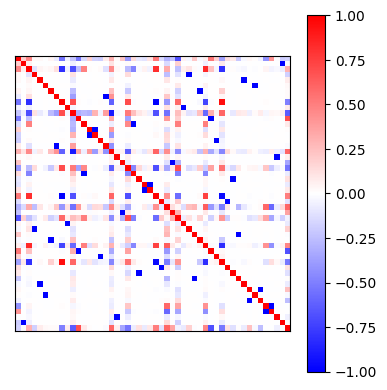

[50, 10000]


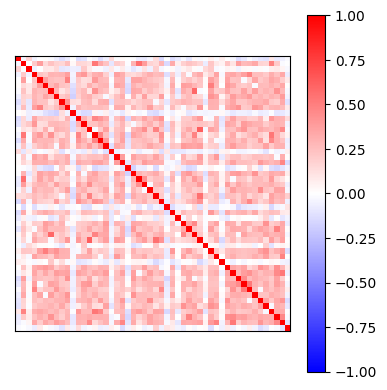

In [77]:
from utils import sh

W = sae.weight.detach().T
print(sh(W))
W_cos = F.cosine_similarity(W[:, None], W[None, :], dim=-1)
plt.figure(figsize=(4, 4))
plt.imshow(W_cos, vmin=-1, vmax=1, cmap="bwr")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

W = guess.T.detach()
print(sh(W))
W_cos = F.cosine_similarity(W[:, None], W[None, :], dim=-1)
plt.figure(figsize=(4, 4))
plt.imshow(W_cos, vmin=-1, vmax=1, cmap="bwr")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()